# SEAS 6401 Final Project 
This notebook shows the data loading, analysis, and modeling of DonorsChoose.org data (https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Spark and multiprocessing is used in this notebook in an effort to boost performance and speed of certain steps. This notebook was run in a Google Colab environment.

In [ ]:
# Install Spark-related dependencies.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

# Install needed packages.
!pip install -q findspark
!pip install pyspark
!pip install koalas
!pip install --upgrade pyarrow
!pip install --upgrade hyperopt
!pip install --upgrade gensim
!pip install --upgrade tqdm
!pip install --upgrade fastai
!pip install --upgrade transformers
!pip install --upgrade imbalanced-learn

     |████████████████████████████████| 204.2MB 28kB/s 
     |████████████████████████████████| 204kB 43.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=08a47c138a4bf338cb8f448dfcbaa204824b9b5b2df83b9de43752b7c349a091
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
     |████████████████████████████████| 778kB 5.8MB/s 
     |████████████████████████████████| 17.7MB 447kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 972kB 5.5MB/s 
  Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2
     |████████████████████████████████| 24.2MB 52.8MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
  

In [ ]:
############
# Built-In #
############
import gc
import logging
import multiprocessing as mp
import os
import random
import re
import string
import time
import warnings

###############
# Third-Party #
###############
from fastai.text.all import *
import gensim
import gensim.downloader
from google.colab import drive
from hyperopt import fmin, hp, space_eval, SparkTrials, STATUS_OK, tpe
from hyperopt.plotting import main_plot_histogram, main_plot_history
from imblearn.over_sampling import RandomOverSampler
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
import spacy
import torch
from tqdm import tqdm
from wordcloud import WordCloud

# Set up TQDM.
tqdm.pandas()

# Download NLTK packages.
nltk.download('punkt');

# Set up required environment variables.
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.0.1-bin-hadoop2.7'
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

# Set up SparkSession for Spark operations.
spark = (
    SparkSession
        .builder
        .appName('seas6401-project')
        .config('spark.debug.maxToStringFields', '9999')
        .config(
            'spark.sql.parquet.fs.optimized.committer.optimization-enabled', 
            'true'
        )
        .config('spark.driver.memory', '16g')
        .getOrCreate()
)

# Import Koalas after SparkSession is set up so it uses
# it by default instead of creating its own
import databricks.koalas as ks

# Set Koalas options.
ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Notebook Options

In [ ]:
# Set the below to `False` if a preprocessed data file
# exists already. If set to `True`, it will regenerate
# the preprocessed data and overwrite the file specified
# below so be careful.
use_preprocessed_data = True 

# Set the name of the preprocessed file to load if 
# the above is `False` or the file to create if the
# above is `True`.
preprocessed_data_file = 'complete_data_transformed.csv'

## Data Loading

In [ ]:
drive.mount('/data/', force_remount = True)
data_dir = '/data/My Drive/Colab Notebooks/SEAS 6401/Data'
!ls '{data_dir}'

Mounted at /data/
complete_data_transformed.csv	  essays.csv	  outcomes.csv
complete_data_transformed_mp.csv  fastai_wce.pkl


In [ ]:
outcomes = pd.read_csv(f'{data_dir}/outcomes.csv')

# Convert the `is_exciting` field from a binary string
# field to a binary 1/0 field.
outcomes['is_exciting'] = outcomes['is_exciting'].apply(
    lambda x: 1 if x == 't' else 0
)

outcomes.head()

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,ffffc4f85b60efc5b52347df489d0238,0,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
1,ffffac55ee02a49d1abc87ba6fc61135,0,f,t,t,f,t,f,f,57.0,0.0,7.0
2,ffff97ed93720407d70a2787475932b0,0,f,t,t,t,t,t,f,100.0,0.0,3.0
3,ffff418bb42fad24347527ad96100f81,0,f,f,t,t,f,f,f,100.0,0.0,1.0
4,ffff2d9c769c8fb5335e949c615425eb,1,t,t,t,t,f,t,f,63.0,6.0,2.0


In [ ]:
essays = pd.read_csv(f'{data_dir}/essays.csv', usecols = ['projectid', 'essay'])
essays.head()

,projectid,essay
0,ffffc4f85b60efc5b52347df489d0238,"I am a fourth year fifth grade math teacher. The school I teach in is a fifth and sixth grade public school and is a Title One school which means that 95% of our students get free lunch. Presently, I am in the process of completing a Masters degree in Technology in Education through Lesley University. My coursework through Lesley University is allowing me to continue to be a lifelong learner and allow my students to learn in an environment that they can be successful in. Technology has a huge impact on my students' involvement in the classroom. I would like the opportunity to introduce mor..."
1,ffffac55ee02a49d1abc87ba6fc61135,"Can you imagine having to translate everything you read into sign language and relate it to what you already know? Help us do just that by giving us the camera that will record our stories and interpretations! \r\n\r\nMy students are all deaf or hard of hearing who are struggling to master reading and language skills at the same time. My students have varying levels of benefit from hearing aids or cochlear implants, and they are all using sign language either for language support or for full communication. In addition to being deaf, my students are also in a Title 1 school in a Title 1 co..."
2,ffff97ed93720407d70a2787475932b0,"Hi. I teach a wonderful group of 4-5 year old Kindergarten students. They come in wanting and willing to learn new and exciting things each and every day. I work hard to ensure that my students get the most out of the entire school year. \r\n\r\nFor the most part, this is the first academic experiences my students have. That's why it is vitally important to ensure that they keep the excitement and joy for learning throughout the entire school year and take it with them to first grade. To ensure this happens, there are certain supplies that every classroom needs. \r\n\r\nUnfortunately, w..."
3,ffff7266778f71242675416e600b94e1,"My Kindergarten students come from a variety of backgrounds. As their teacher, it is my duty to provide a wide variety of texts as we begin to learn how to read. \r\n\r\nKindergarten students are excited about school - especially about learning to read. I hope to feed their excitement by introducing new types of text, and different reasons for learning. Learning to read non-fiction text is often a struggle for beginning readers, but ""Let's Find Out"" magazine makes it fun. \r\n\r\n""Let's Find Out"" is an awesome magazine that keeps students entertained with colorful thematic stories presente..."
4,ffff418bb42fad24347527ad96100f81,"All work and no play makes school a dull place to learn. Our class is a 4th grade general education classroom. \r\n\r\nIn an effort to go green our district has cut WAY down on the number of copies that can be made. This makes it very difficult to accurately judge where students are in the learning process. With the games requested cover all subject areas so students will be doing less paper pencil activities (going green) and having fun with learning which will increase motivation, and participation. \r\n\r\nThe small group environment provides a safe place for students to try out new..."


In [ ]:
# Merge the essays and outcomes data together to get the final data I want to use.
complete_data = essays.merge(outcomes[['projectid', 'is_exciting']], on = 'projectid', how = 'inner')
complete_data.head()

,projectid,essay,is_exciting
0,ffffc4f85b60efc5b52347df489d0238,"I am a fourth year fifth grade math teacher. The school I teach in is a fifth and sixth grade public school and is a Title One school which means that 95% of our students get free lunch. Presently, I am in the process of completing a Masters degree in Technology in Education through Lesley University. My coursework through Lesley University is allowing me to continue to be a lifelong learner and allow my students to learn in an environment that they can be successful in. Technology has a huge impact on my students' involvement in the classroom. I would like the opportunity to introduce mor...",0
1,ffffac55ee02a49d1abc87ba6fc61135,"Can you imagine having to translate everything you read into sign language and relate it to what you already know? Help us do just that by giving us the camera that will record our stories and interpretations! \r\n\r\nMy students are all deaf or hard of hearing who are struggling to master reading and language skills at the same time. My students have varying levels of benefit from hearing aids or cochlear implants, and they are all using sign language either for language support or for full communication. In addition to being deaf, my students are also in a Title 1 school in a Title 1 co...",0
2,ffff97ed93720407d70a2787475932b0,"Hi. I teach a wonderful group of 4-5 year old Kindergarten students. They come in wanting and willing to learn new and exciting things each and every day. I work hard to ensure that my students get the most out of the entire school year. \r\n\r\nFor the most part, this is the first academic experiences my students have. That's why it is vitally important to ensure that they keep the excitement and joy for learning throughout the entire school year and take it with them to first grade. To ensure this happens, there are certain supplies that every classroom needs. \r\n\r\nUnfortunately, w...",0
3,ffff418bb42fad24347527ad96100f81,"All work and no play makes school a dull place to learn. Our class is a 4th grade general education classroom. \r\n\r\nIn an effort to go green our district has cut WAY down on the number of copies that can be made. This makes it very difficult to accurately judge where students are in the learning process. With the games requested cover all subject areas so students will be doing less paper pencil activities (going green) and having fun with learning which will increase motivation, and participation. \r\n\r\nThe small group environment provides a safe place for students to try out new...",0
4,ffff2d9c769c8fb5335e949c615425eb,"Have you ever had to crowd around an iPad screen to access information? Students are patient with each other, but patience is just not enough when you want to get an assignment completed. Ideally, all students should have an iPad. Considering my budget, it's a dream . I respectfully request 1 iPad. \r\n\r\nMy students attend a K-6 public school in Idaho. They attend intervention to assist them with extra academic support. Their ages range from eight to twelve. These students desperately want to ""catch up"" to their peers, and the approximately twenty-five kids work hard everyday in my class...",1


In [ ]:
print(f'"Outcomes" shape: {outcomes.shape}')
print(f'"Essays" shape:   {essays.shape}')
print(f'Post-join shape:  {complete_data.shape}')

"Outcomes" shape: (619326, 12)
"Essays" shape:   (664098, 2)
Post-join shape:  (619326, 3)


In [ ]:
# Clear up memory
del essays
del outcomes
gc.collect();

## Exploratory Data Analysis

### `is_exciting`
This looks like quite an imbalanced dataset. We will have to potentially do some upsampling if we see modeling doesn't perform well.

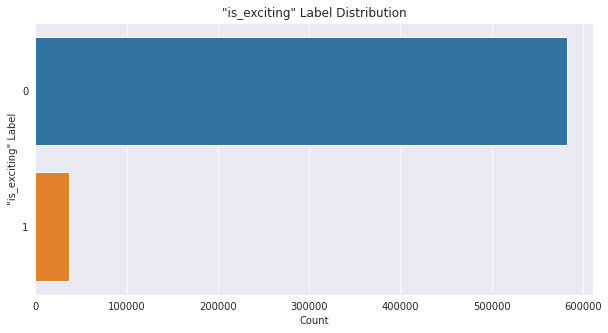

In [ ]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize = (10, 5))
    sns.countplot(y = complete_data['is_exciting'], ax = ax);
    ax.set_ylabel('"is_exciting" Label');
    ax.set_xlabel('Count');
    ax.set_title('"is_exciting" Label Distribution');

### `essay`
There are only a couple NULL values in the `essay` column so we can just safely drop those rows and we won't lose much information.

In [ ]:
print(complete_data.isna().sum())

print(f'\nShape before dropping NULLs: {complete_data.shape}')
complete_data = complete_data.dropna()
print(f'Shape after dropping NULLs: {complete_data.shape}')

projectid      0
essay          3
is_exciting    0
dtype: int64

Shape before dropping NULLs: (619326, 3)
Shape after dropping NULLs: (619323, 3)


In [ ]:
start = time.perf_counter()

def random_color_func(
    word=None, 
    font_size=None, 
    position=None,  
    orientation=None, 
    font_path=None, 
    random_state=None
):
    '''Generate a random hue, saturation, and lightness for word clouds.'''
    random_hue = random.choice([7, 44, 93, 242, 184])
    h = int(360.0 * random_hue / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return 'hsl({}, {}%, {}%)'.format(h, s, l)

# Pull only exciting projects.
exciting_essays = complete_data[complete_data['is_exciting'] == 1]

# Get non-exciting projects.
not_exciting_essays = complete_data[complete_data['is_exciting'] == 0]

# Generate the word cloud for exciting essays.
text_exciting = ' '.join(essay for essay in exciting_essays['essay'])
wordcloud_exciting = WordCloud(
    background_color = '#eaeaf2',
    color_func = random_color_func,
    collocations = False
).generate(text_exciting)

# Generate the word cloud for non-exciting essays.
text_not_exciting = ' '.join(essay for essay in not_exciting_essays['essay'])
wordcloud_not_exciting = WordCloud( 
    background_color = '#eaeaf2',
    color_func = random_color_func,
    collocations = False
).generate(text_not_exciting)
end = time.perf_counter()
print(f'Word cloud generation took {end - start} seconds!')

Word cloud generation took 180.97900586800097 seconds!


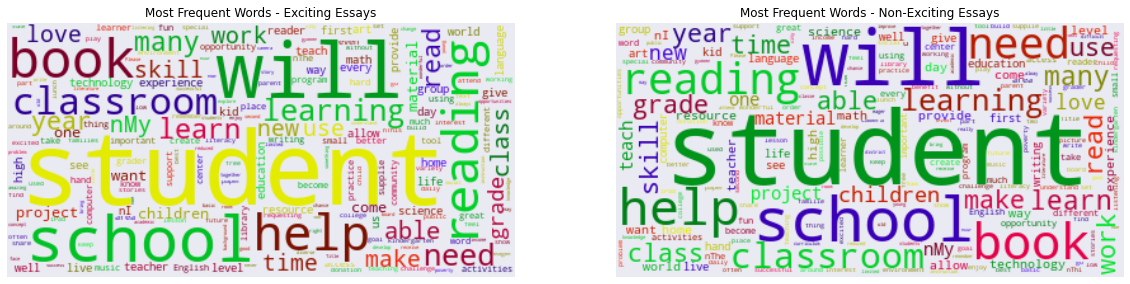

In [ ]:
# Display the generated image:
fig, axes = plt.subplots(1, 2, figsize = (20, 20))
axes[0].imshow(wordcloud_exciting, interpolation = 'bilinear');
axes[0].axis('off');
axes[0].set_title('Most Frequent Words - Exciting Essays');

axes[1].imshow(wordcloud_not_exciting, interpolation = 'bilinear');
axes[1].axis('off');
axes[1].set_title('Most Frequent Words - Non-Exciting Essays');

# Delete to free up memory
del wordcloud_exciting
del exciting_essays
del text_exciting
del wordcloud_not_exciting
del not_exciting_essays
del text_not_exciting
gc.collect();

Let's explore how large essays are and if there's any relationship between essay character- and word-length to whether it's considered exciting or not.

In [ ]:
def word_count(text):
    return len(text.split())
  
def char_count(text):
    return len(text)
  
complete_data['essay_word_count'] = complete_data['essay'].apply(word_count)
complete_data['essay_character_count'] = complete_data['essay'].apply(char_count)
complete_data.head()

,projectid,essay,is_exciting,essay_word_count,essay_character_count
0,ffffc4f85b60efc5b52347df489d0238,I am a fourth year fifth grade math teacher. T...,0,443,2615
1,ffffac55ee02a49d1abc87ba6fc61135,Can you imagine having to translate everything...,0,199,1155
2,ffff97ed93720407d70a2787475932b0,Hi. I teach a wonderful group of 4-5 year old ...,0,226,1327
3,ffff418bb42fad24347527ad96100f81,All work and no play makes school a dull place...,0,183,1081
4,ffff2d9c769c8fb5335e949c615425eb,Have you ever had to crowd around an iPad scre...,1,465,2799


It doesn't look like there's a really compelling difference in word counts or character counts in essays between exciting and non-exciting essays.

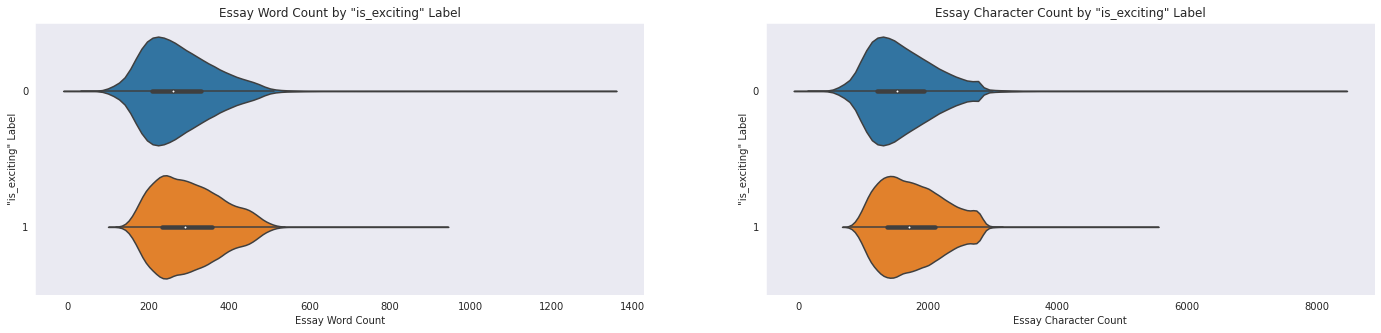

In [ ]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(1, 2, figsize = (24, 5))

    sns.violinplot(
        y = complete_data['is_exciting'].astype(str), 
        x = complete_data['essay_word_count'], 
        ax = axes[0]
    );
    axes[0].set_title('Essay Word Count by "is_exciting" Label');
    axes[0].set_ylabel('"is_exciting" Label');
    axes[0].set_xlabel('Essay Word Count');

    sns.violinplot(
        y = complete_data['is_exciting'].astype(str), 
        x = complete_data['essay_character_count'], 
        ax = axes[1]
    );
    axes[1].set_title('Essay Character Count by "is_exciting" Label');
    axes[1].set_ylabel('"is_exciting" Label');
    axes[1].set_xlabel('Essay Character Count');

In [ ]:
# Drop the word and character count columns now since we don't need them.
complete_data = complete_data.drop(
    columns = ['essay_word_count', 'essay_character_count']
)

complete_data.head()

,projectid,essay,is_exciting
0,ffffc4f85b60efc5b52347df489d0238,I am a fourth year fifth grade math teacher. T...,0
1,ffffac55ee02a49d1abc87ba6fc61135,Can you imagine having to translate everything...,0
2,ffff97ed93720407d70a2787475932b0,Hi. I teach a wonderful group of 4-5 year old ...,0
3,ffff418bb42fad24347527ad96100f81,All work and no play makes school a dull place...,0
4,ffff2d9c769c8fb5335e949c615425eb,Have you ever had to crowd around an iPad scre...,1


## Feature Engineering/Text Preprocessing
The steps we will take to preprocess the text here are as follows:
1. Replace "\r\\\\n" in text.
2. Lowercase the text.
3. Remove extra spaces.
4. Tokenize text using spaCy.
5. Remove punctuation.
6. Remove stop words.
7. Lemmatize text.
8. Remove punctuation once more to check for leftovers.

The `multiprocessing` library is used here to try to speed up processing. Normally, doing this text processing serially will take around 10 hours. Using the `multiprocessing` library, it takes around 1.5 hours for processing and CSV creation.

In [ ]:
# Get the appropriate spaCy model to use.
spacy_model = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

################################
# TEXT PREPROCESSING FUNCTIONS #
################################
def _remove_punctuation(text, step):
    if step == 'initial':
        return [
            token for token in text if re.sub(r'[\W_]+', ' ', token.text)
            not in string.punctuation
            and re.sub(r'([\W_])+', ' ', token.text) != ' '
            and re.sub(r'([\W_])+', ' ', token.text) != ''
        ]
    elif step == 'last':
        return [re.sub(r'[\W_]+', ' ', token) for token in text]

def _remove_stop_words(text):
    return [token for token in text if not token.is_stop]

def _lemmatize(text):
    return [token.lemma_ for token in text]

def _preprocess_text(text):
    # Remove strange carriage return from essays.
    step_1 = re.sub('\r\\\\n', ' ', text)

    # Lowercase text and remove extra spaces.
    step_2_3 = ' '.join(
        [word.lower() for word in str(step_1).split()]
    )

    # Tokenize text with spaCy.
    step_4 = spacy_model(step_2_3)

    # Remove punctuation.
    step_5 = _remove_punctuation(step_4, step = 'initial')

    # Remove stop words.
    step_6 = _remove_stop_words(step_5)

    # Lemmatize text.
    step_7 = _lemmatize(step_6)

    # Remove punctuation again.
    step_8 = _remove_punctuation(step_7, step = 'last')

    # Remake sentence with new cleaned up tokens.
    return ' '.join(step_8)

def preprocess_text(data_partition):
    block = data_partition[0]
    data = data_partition[1]

    print(f'Starting block {block}...')
    data['essay_preprocessed'] = data['essay'].apply(_preprocess_text)
    print(f'Block {block} finished!')

    return data

if use_preprocessed_data:
    complete_data_processed = pd.read_csv(f'{data_dir}/{preprocessed_data_file}')
    complete_data_processed = complete_data_processed.fillna('')
else:
    partitions = mp.cpu_count()

    # Split DataFrame into blocks and pool multiprocess
    data_partitions = np.array_split(complete_data, partitions)
    pool = mp.Pool(partitions)

    # Start multiprocessing pool
    start = time.perf_counter()
    complete_data_processed = pd.concat(
        list(
            pool.imap(
                preprocess_text,
                enumerate(data_partitions)
            )
        )
    )
    pool.close()
    pool.join()
    time.sleep(1)
    end = time.perf_counter()
    print(f'Text processing took {end - start} seconds!')

    complete_data_processed[['projectid', 'essay_preprocessed', 'is_exciting']] \
        .to_csv(f'{data_dir}/{preprocessed_data_file}', index = False)

complete_data_processed.head()

,projectid,essay_preprocessed,is_exciting
0,ffffc4f85b60efc5b52347df489d0238,fourth year fifth grade math teacher school teach fifth sixth grade public school title school mean 95 student free lunch presently process complete master degree technology education lesley university coursework lesley university allow continue lifelong learner allow student learn environment successful technology huge impact student involvement classroom like opportunity introduce technology classroom need help wonderful people like like introduce student program imath imath program integrate ipod math curriculum allow student practice math fact construct project create podcast listen te...,0
1,ffffac55ee02a49d1abc87ba6fc61135,imagine have translate read sign language relate know help give camera record story interpretation student deaf hard hear struggle master reading language skill time student vary level benefit hear aids cochlear implant sign language language support communication addition deaf student title 1 school title 1 county easy use video camera help student support read help record translation story real life item sign language interpretation video element help support reading language skill form student easily relate learn donation project extremely beneficial support student language deficit stu...,0
2,ffff97ed93720407d70a2787475932b0,hi teach wonderful group 4 5 year old kindergarten student come want willing learn new exciting thing day work hard ensure student entire school year academic experience student vitally important ensure excitement joy learn entire school year grade ensure happen certain supply classroom need unfortunately past present budget cut supply readily available make increasingly difficult ensure student continue productive excited learn day day chart tablet marker write experience chart sentence strip activity bulletin board crayon art learning safety tag field trip electric sharpener allow studen...,0
3,ffff418bb42fad24347527ad96100f81,work play make school dull place learn class 4th grade general education classroom effort green district cut way number copy make difficult accurately judge student learning process game request cover subject area student paper pencil activity go green have fun learning increase motivation participation small group environment provide safe place student try new idea feel free risk work small group solve problem present game allow child develop problem solve ability fun way cross curricular game request student able participate type learn environment help learn fun student make possible stu...,0
4,ffff2d9c769c8fb5335e949c615425eb,crowd ipad screen access information student patient patience want assignment complete ideally student ipad consider budget dream respectfully request 1 ipad student attend k 6 public school idaho attend intervention assist extra academic support age range student desperately want catch peer approximately kid work hard everyday class achieve goal grade student divide different session academic strength weakness literally child beg use personal ipad access information use educational tool schedule usage way find fair avenue ensure student exposure ideal learn tool ipad schedule day student ...,1


Let's compare the original essay to the new processed essay.

In [ ]:
# Randomly pick indices to show.
idx = random.randint(0, complete_data.shape[0] - 1)
project_id = complete_data.loc[idx, 'projectid']
print('ORIGINAL TEXT 1'.center(50, '='))
print(repr(complete_data.loc[idx, 'essay']))

print('PROCESSED TEXT 1'.center(50, '='))
row = complete_data_processed[complete_data_processed['projectid'] == project_id]
print(row.loc[:, 'essay_preprocessed'].values[0])

print('\n' + '=' * 50, end = '\n\n')
idx = random.randint(0, complete_data.shape[0] - 1)
project_id = complete_data.loc[idx, 'projectid']
print('ORIGINAL TEXT 2'.center(50, '='))
print(repr(complete_data.loc[idx, 'essay']))

print('PROCESSED TEXT 2'.center(50, '='))
row = complete_data_processed[complete_data_processed['projectid'] == project_id]
print(row.loc[:, 'essay_preprocessed'].values[0])

=================ORIGINAL TEXT 1==================
'Over the many years of teaching I have learned that most of my students are visual learners, especially in math.\r\\n\r\\nOne of the most difficult concepts to teach is the adding and subtracting of two digit numbers.  My students sometimes do not understand what to do with "too many ones!"  What will help them a great deal are base ten blocks.  These manipulatives will give  my students hands-on experience and allow them to "see the numbers" and come up with a correct answer.  \r\\n\r\\nThe base ten blocks will be a great learning tool during whole class instruction and when they are reinforcing the concept in their small groups.  By donating to our class, you, the generous donors, will help our class better understand place value and making the leap from ones to tens.   \r\\n\r\\nI want my students to love math, and with your help and base ten blocks, I know they will achieve that goal!\r\\n'
=================PROCESSED TEXT 1=======

Let's regenerate the word cloud for the new new preprocessed essays and see how/if it changes.

In [ ]:
start = time.perf_counter()

# Pull only exciting projects.
exciting_essays = complete_data_processed[complete_data_processed['is_exciting'] == 1]

# Get non-exciting projects.
not_exciting_essays = complete_data_processed[complete_data_processed['is_exciting'] == 0]

# Generate the word cloud for exciting essays.
text_exciting = ' '.join(essay for essay in exciting_essays['essay_preprocessed'])
wordcloud_exciting = WordCloud(
    background_color = '#eaeaf2',
    color_func = random_color_func,
    collocations = False
).generate(text_exciting)

# Generate the word cloud for non-exciting essays.
text_not_exciting = ' '.join(essay for essay in not_exciting_essays['essay_preprocessed'])
wordcloud_not_exciting = WordCloud( 
    background_color = '#eaeaf2',
    color_func = random_color_func,
    collocations = False
).generate(text_not_exciting)
end = time.perf_counter()
print(f'Word cloud generation took {end - start} seconds!')

Word cloud generation took 107.59229713099921 seconds!


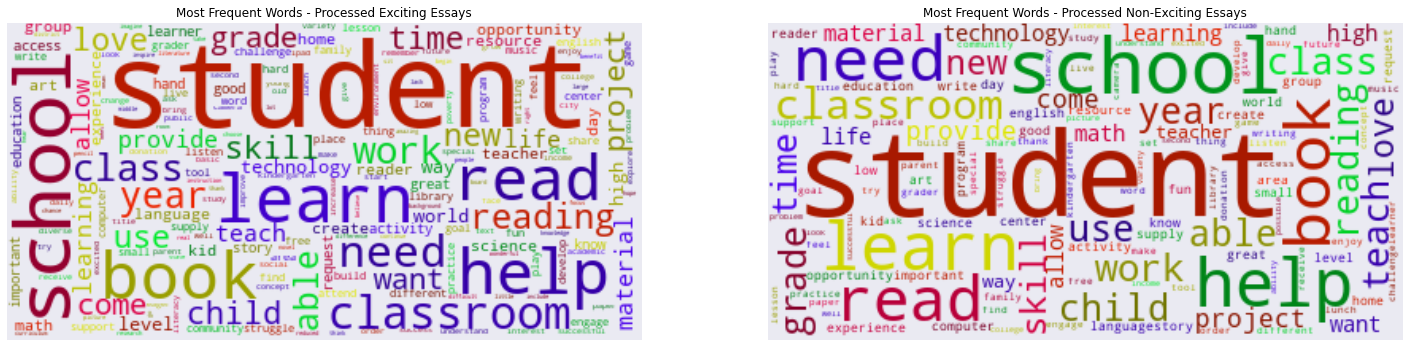

In [ ]:
# Display the generated image:
fig, axes = plt.subplots(1, 2, figsize = (25, 25))
axes[0].imshow(wordcloud_exciting, interpolation = 'bilinear');
axes[0].axis('off');
axes[0].set_title('Most Frequent Words - Processed Exciting Essays');

axes[1].imshow(wordcloud_not_exciting, interpolation = 'bilinear');
axes[1].axis('off');
axes[1].set_title('Most Frequent Words - Processed Non-Exciting Essays');

# Delete to free up memory
del wordcloud_exciting
del exciting_essays
del text_exciting
del wordcloud_not_exciting
del not_exciting_essays
del text_not_exciting
gc.collect();

## Train-Test Split

In [ ]:
# Do 80/20 train-test split.
X_train, X_test, y_train, y_test = train_test_split(
    complete_data_processed['essay_preprocessed'],
    complete_data_processed['is_exciting'],
    test_size = 0.2,
    stratify = complete_data_processed['is_exciting'],
    random_state = 1
)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape:  {X_test.shape}')

Training shape: (495458,)
Testing shape:  (123865,)


## Modeling
This next section goes through three different approaches in text modeling to see what performs best.

In [ ]:
# Helper functions
def plot_tuning_results(trials):
    with sns.axes_style('darkgrid'):
        fig = plt.figure(figsize = (25, 5))
        fig.subplots_adjust(wspace = 0.5)
        ax = fig.add_subplot(1, 3, 1)
        main_plot_histogram(trials, do_show = False);

        ax = fig.add_subplot(1, 3, 2)
        main_plot_history(trials, do_show = False);

def get_tuned_test_results(
    X_train, 
    y_train, 
    X_test,
    y_test, 
    search_space, 
    best_hyperparams, 
    model
):
    # Get the actual best hyperparameter values instead of 
    # just the indices and apply them to the pipeline
    best = space_eval(search_space, best_hyperparams)
    print(f'Best hyperparameters are: {best}')
    model = model.set_params(**best)

    # Get test results of best parameters
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print(classification_report(y_test, y_preds))

### Approach 1: Bag-of-Words
The first approach I am experimenting with is creating a bag-of-words represenation of the preprocessed text data and giving that to a logistic regression model to create a baseline model.

#### Baseline Model
This baseline model uses word frequencies and a logistic regression model. I do 10-fold cross-validation in order to get a more accurate estimate of model performance.

In [ ]:
vectorizer = CountVectorizer()
model = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
baseline_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])
cv_scores = cross_validate(
    estimator = baseline_pipeline, 
    X = X_train,
    y = y_train,
    scoring = 'f1_macro',
    cv = 10,
    verbose = 3,
    n_jobs = -1
)
time.sleep(1)

print(f'Cross-validation results: {cv_scores["test_score"].tolist()}')
print(f'Average CV F1 score:      {cv_scores["test_score"].mean()}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  5.0min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.3min finished


Cross-validation results: [0.4831468359356704, 0.4861206137081713, 0.48211829409461754, 0.48363378256411327, 0.48527014835616006, 0.4825587022991886, 0.4897173943803, 0.48501262247666344, 0.48109968957292215, 0.4883941833949672]
Average CV F1 score:      0.4847072266782774


In [ ]:
baseline_pipeline.fit(X_train, y_train)
y_preds = baseline_pipeline.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80    116523
           1       0.10      0.58      0.17      7342

    accuracy                           0.67    123865
   macro avg       0.53      0.63      0.48    123865
weighted avg       0.91      0.67      0.76    123865



##### Hyperparameter Tuning
Now that we have a baseline model, let's see if we can improve upon it by doing some hyperparameter tuning.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    model_c = params['model__C']
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']

    # Create the pipeline.
    vectorizer = CountVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = LogisticRegression(
        C = model_c, 
        class_weight = 'balanced'
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3, # I'm only doing 3-fold validation here to save time.
            scoring = 'f1_macro'
        ).mean()

    # Clear up memory.
    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to maximize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
  'model__C': hp.choice('C', [0.1, 1, 10, 100]),
  'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (1, 2), (2, 2)]),
  'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

# Use SparkTrials to tune concurrently
spark_trials = SparkTrials(parallelism = 2)
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = spark_trials,
    max_evals = 12 # Set to half of number of param combos
)

100%|██████████| 12/12 [1:50:01<00:00, 550.11s/trial, best loss: -0.5375855598725153]


Total Trials: 12: 12 succeeded, 0 failed, 0 cancelled.


Below are the hyperparameter tuning graphs over the tuning trials.

Showing Histogram of 12 jobs
avg best error: -0.5375855598725153


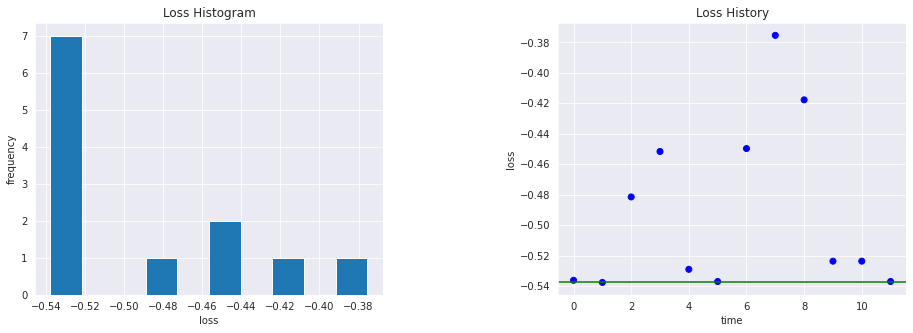

In [ ]:
plot_tuning_results(spark_trials)

In [ ]:
# Defining the pipeline but not setting any parameters
# as that will be set below from the best hyperparameters
vectorizer = CountVectorizer()
model = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline
)

Best hyperparameters are: {'model__C': 0.1, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (2, 2)}
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    116523
           1       0.14      0.13      0.13      7342

    accuracy                           0.90    123865
   macro avg       0.54      0.54      0.54    123865
weighted avg       0.90      0.90      0.90    123865



In [ ]:
# Free up memory.
del vectorizer
del model
del pipeline
del spark_trials
gc.collect();

#### Model Iteration 1: TF-IDF
Our best baseline model after hyperparameter tuning performed at **53.75%** F1 (54% F1 on the test set). For this iteration, I replace the `CountVectorizer` with the `TfidfVectorizer` in order to change the feature space from simple word frequency to doing TF-IDF calculations. Let's see if TF-IDF vectorization does better.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    model_c = params['model__C']
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']

    # Create the pipeline.
    vectorizer = TfidfVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = LogisticRegression(
        C = model_c, 
        class_weight = 'balanced' 
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3, # I'm only doing 3-fold validation here to save time.
            scoring = 'f1_macro',
        ).mean()

    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to maximize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
  'model__C': hp.choice('C', [0.1, 1, 10, 100]),
  'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (1, 2), (2, 2)]),
  'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

# Use SparkTrials to tune concurrently
spark_trials = SparkTrials(parallelism = 2)
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = spark_trials,
    max_evals = 12
)

100%|██████████| 12/12 [1:53:14<00:00, 566.22s/trial, best loss: -0.5494561348377068]

Total Trials: 12: 12 succeeded, 0 failed, 0 cancelled.


Switching out the `CountVectorizer` with the `TfidfVectorizer` seemed to provide some lift to the score. The new best F1 score I was able to get was **54.94%**. 

Showing Histogram of 12 jobs
avg best error: -0.5494561348377068


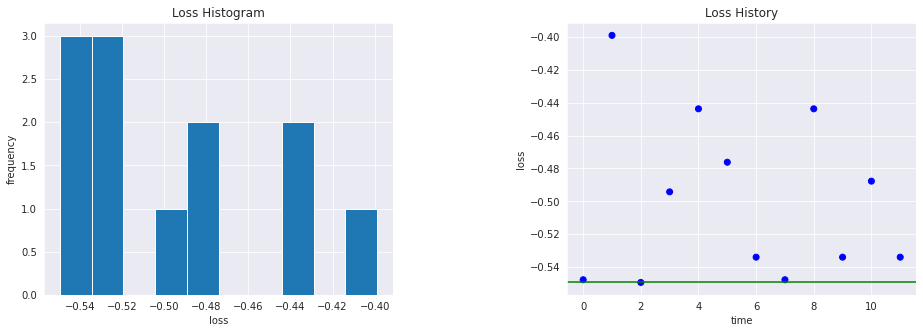

In [ ]:
plot_tuning_results(spark_trials)

In [ ]:
# Recreate pipeline used in objective function but do not set
# any parameters since we will set it later below.
vectorizer = TfidfVectorizer()
model = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline
)

Best hyperparameters are: {'model__C': 1, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (2, 2)}
              precision    recall  f1-score   support

           0       0.95      0.89      0.92    116523
           1       0.13      0.26      0.18      7342

    accuracy                           0.86    123865
   macro avg       0.54      0.58      0.55    123865
weighted avg       0.90      0.86      0.88    123865



In [ ]:
# Free up memory.
del vectorizer
del model
del pipeline
del spark_trials
gc.collect();

#### Model Iteration 2: Random Forest
Since TF-IDF vectorization seems to work better than word frequencies, let's keep that. I will change up the model for this iteration; instead of a logistic regression model, let's try a random forest.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    model_n_estimators = params['model__n_estimators']
    model_class_weight = params['model__class_weight']
    model_ccp_alpha = params['model__ccp_alpha']
    model_max_depth = params['model__max_depth']
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']

    # Create the pipeline.
    vectorizer = TfidfVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = RandomForestClassifier(
        n_estimators = model_n_estimators,
        class_weight = model_class_weight,
        ccp_alpha = model_ccp_alpha,
        max_depth = model_max_depth
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3,
            scoring = 'f1_macro',
        ).mean()

    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to maximize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
  'model__n_estimators': hp.choice('n_estimators', [10, 25, 50, 100]),
  'model__class_weight': hp.choice('class_weight', ['balanced', 'balanced_subsample']),
  'model__ccp_alpha': hp.choice('ccp_alpha', [0, 0.1, 1, 10]),
  'model__max_depth': hp.choice('max_depth', [10, 20]),
  'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (2, 2)]),
  'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

# Use SparkTrials to tune concurrently
spark_trials = SparkTrials(parallelism = 2)
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = spark_trials,
    max_evals = 100
)

100%|██████████| 100/100 [11:27:28<00:00, 412.49s/trial, best loss: -0.5346332327579689]


Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.


Looks like a random forest doesn't do as well as a logistic regression - it got a **53.46%** F1 from tuning and performed with a 53% F1 on the test set.

Showing Histogram of 100 jobs
avg best error: -0.5346332327579689


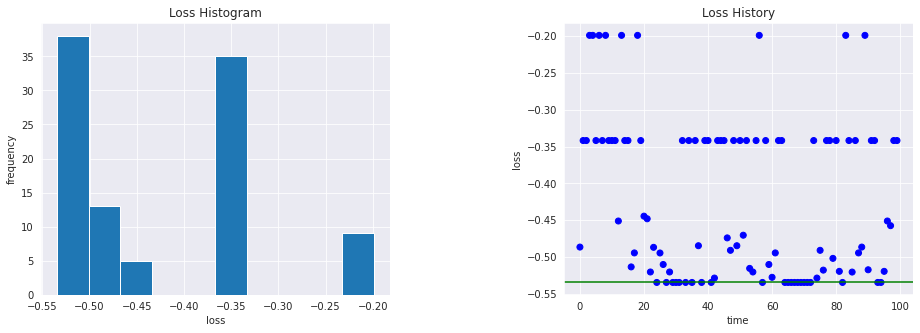

In [ ]:
plot_tuning_results(spark_trials)

In [ ]:
# Recreate pipeline used in objective function but do not set
# any parameters since we will set it later below.
vectorizer = TfidfVectorizer()
model = RandomForestClassifier(n_jobs = -1)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline
)

Best hyperparameters are: {'model__ccp_alpha': 0, 'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 100, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.95      0.86      0.90    116523
           1       0.11      0.28      0.16      7342

    accuracy                           0.82    123865
   macro avg       0.53      0.57      0.53    123865
weighted avg       0.90      0.82      0.86    123865



In [ ]:
# Free up memory.
del vectorizer
del model
del pipeline
del spark_trials
gc.collect();

#### Model Iteration 3: Upsampling
Due to the imbalanced nature of our labels, maybe upsampling will help in the performance of the model. I will stick to a logistic regression model along with the TF-IDF vectorizer since, based on the previous model iterations, those are what performed the best thus far. Note that I don't upsample the test set; this is on purpose. When upsampling, downsampling, or augmenting data for the purposes of training, the augmentations should **only be applied to the training data**.

In [ ]:
sampler = RandomOverSampler(random_state = 1)
X_train_resampled, y_train_resampled = sampler.fit_resample(
    X_train.values.reshape(-1, 1), 
    y_train.values.reshape(-1, 1)
)

print(f'Old training shape: {X_train.shape}')
print(f'New training shape: {X_train_resampled.shape}')

Old training shape: (495458,)
New training shape: (932180, 1)


In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    model_c = params['model__C']
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']

    # Create the pipeline.
    vectorizer = TfidfVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = LogisticRegression(
        C = model_c, 
        class_weight = 'balanced' 
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            # Now I'm using the resampled data from above
            X = pd.DataFrame(X_train_resampled)[0], 
            y = pd.DataFrame(y_train_resampled)[0],
            cv = 3, # I'm only doing 3-fold validation here to save time.
            scoring = 'f1_macro',
        ).mean()

    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to maximize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
  'model__C': hp.choice('C', [0.1, 1, 10, 100]),
  'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (2, 2)]),
  'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

# Use SparkTrials to tune concurrently
spark_trials = SparkTrials(parallelism = 2)
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = spark_trials,
    max_evals = 8
)

100%|██████████| 8/8 [1:20:33<00:00, 604.19s/trial, best loss: -0.9775790768976638]


Total Trials: 8: 8 succeeded, 0 failed, 0 cancelled.


Look at that! 97.75% F1 when upsampled looks super good, but this is on the training set. We need to see how it does with the test set.

Showing Histogram of 8 jobs
avg best error: -0.9775790768976638


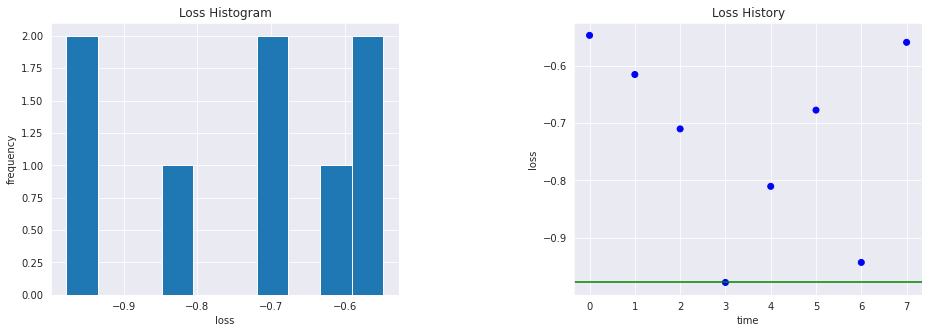

In [ ]:
plot_tuning_results(spark_trials)

In [ ]:
# Recreate pipeline used in objective function but do not set
# any parameters since we will set it later below.
vectorizer = TfidfVectorizer()
model = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = pd.DataFrame(X_train_resampled)[0],
    y_train = pd.DataFrame(y_train_resampled)[0],
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline
)

Best hyperparameters are: {'model__C': 100, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (2, 2)}
              precision    recall  f1-score   support

           0       0.94      0.97      0.96    116523
           1       0.15      0.09      0.11      7342

    accuracy                           0.92    123865
   macro avg       0.55      0.53      0.53    123865
weighted avg       0.90      0.92      0.91    123865



In [ ]:
# Free up memory.
del vectorizer
del model
del pipeline
del spark_trials
gc.collect();

Looks like upsampling didn't have much of an improvement; in fact, it looks like it performed worse - 53% F1 compared to the 55% we got above.

### Approach 2: Word Embeddings
This approach will create word embeddings instead of using TF-IDF or word frequencies as features. The embedding model I will test out is Word2Vec. What the Word2Vec model does is turn words into _n_-dimensional vectors of numbers that attempt to capture the relationships between words; in other words, the Word2Vec model tries to learn how our language works. Words that are closely related to each other should be, theoretically, closer together (distance-wise) while words that are unrelated should be farther apart.

#### Word2Vec Model
Instead of training a Word2Vec model from scratch, I am using a pretrained model trained on Google News to save on time. The pretrained model already has many vectors for words and it was trained on a much larger corpus than our data so it should be more useful.

In [ ]:
w2v_vectors = gensim.downloader.load('word2vec-google-news-300')
w2v_vectors.init_sims()

Just to show how Word2Vec works, I graph the top 30 most similar words in relation to a word list. Since Word2Vec vectors are generally multi-dimensional (300 in this case), I use T-SNE to attempt to reduce it down to two dimensions so I can visualize it.

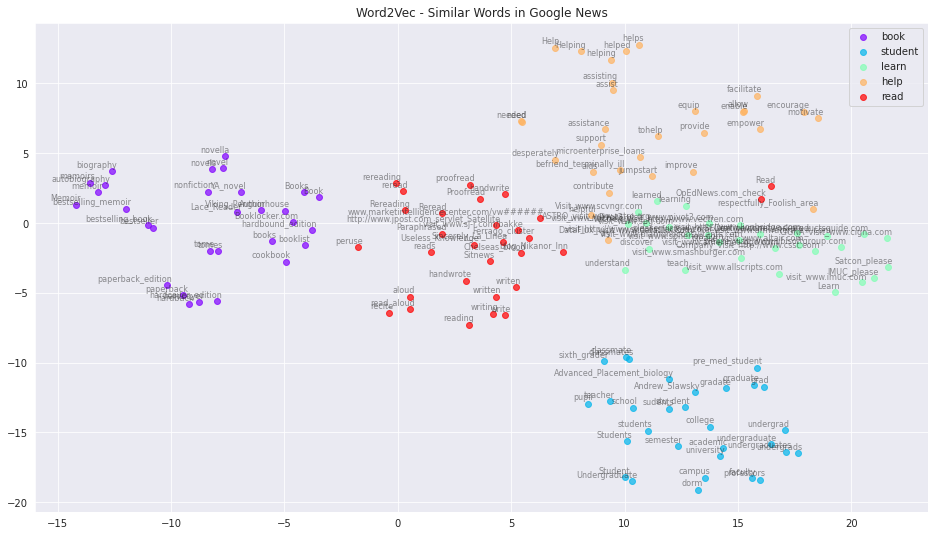

In [ ]:
def plot_embedding_vectors(word_list, model, figsize=(16, 9), alpha=0.7, title=None):
    embedding_clusters = []
    word_clusters = []
    for word in word_list:
        embeddings = []
        words = []
        for similar_word, _ in model.most_similar(word, topn = 30):
            words.append(similar_word)
            embeddings.append(model[similar_word])

        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne = TSNE(
        perplexity = 15, 
        n_components = 2, 
        init = 'pca', 
        n_iter = 3500, 
        random_state = 1
    )
    embeddings = np.array(
        tsne.fit_transform(embedding_clusters.reshape(n * m, k))
    ).reshape(n, m, 2)

    # Plot TSNE
    fig = plt.figure(figsize = figsize)
    colors = cm.rainbow(np.linspace(0, 1, len(word_list)))

    for label, embeddings, words, color in zip(word_list, embeddings, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color = color, alpha = alpha, label = label);
        for i, word in enumerate(words):
            plt.annotate(
                word, 
                alpha = 0.5, 
                xy = (x[i], y[i]), 
                xytext = (5, 2),
                textcoords='offset points', 
                ha = 'right', 
                va = 'bottom', 
                size = 8
            )
        plt.legend(loc = 'best')
        plt.title(title)

word_list = ['book', 'student', 'learn', 'help', 'read']
with sns.axes_style('darkgrid'):
    plot_embedding_vectors(word_list, w2v_vectors, title = 'Word2Vec - Similar Words in Google News')

Now I need to calculate the document embeddings for each essay. The way I calculate document embeddings is by getting the word embeddings for each word in an essay and averaging them together.

In [ ]:
# Get the appropriate spaCy model to use.
spacy_model = spacy.load('en_core_web_sm', disable = ['tagger', 'parser', 'ner'])

def _tokenize(text):
    tokens = spacy_model(text)
    tokens = [token.text.lower() for token in tokens]

    return tokens

def _get_embedding_helper(model, tokens):
    word_embeddings = []

    # Get the embedding vectors from the model.
    try:
        model_vocab = model.vocab
        normed_vectors = model.vectors_norm
    except:
        model_vocab = model.wv.vocab
        normed_vectors = model.wv.vectors_norm

    # Get embeddings for each token.
    for token in tokens:
        if token in model_vocab:
            word_embeddings.append(normed_vectors[model_vocab[token].index])
    
    # Set word embeddings to zero if none of the tokens are found.
    word_embeddings.append(np.zeros(model.vector_size,))

    return word_embeddings

def get_embedding(model, text):
    # Tokenize text.
    tokens = _tokenize(text)

    # Get embeddings for each individual word in the essay.
    word_embeddings = _get_embedding_helper(model, tokens)
    
    # Calculate the entire "document" embedding by taking the mean
    # of all the word embedding vectors. This can also be summed,
    # but it is generally averaged in practice.
    doc_embedding = gensim.matutils.unitvec(
        np.array(word_embeddings).mean(axis = 0)
    ).astype(np.float32)

    return doc_embedding

X_train_vectorized = np.vstack(
    X_train.progress_apply(
        lambda x: get_embedding(w2v_vectors, x)
    )
)

X_test_vectorized = np.vstack(
    X_test.progress_apply(
        lambda x: get_embedding(w2v_vectors, x)
    )
)

100%|██████████| 123865/123865 [01:44<00:00, 1187.43it/s]


#### Model Iteration 1: Logistic Regression
I'll run a logistic regression model on the embeddings to see how it performs.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    model_c = params['C']

    # Create the model.
    model = LogisticRegression(
        C = model_c, 
        class_weight = 'balanced'
    )

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = model, 
            X = X_train_vectorized, 
            y = y_train,
            cv = 3, # I'm only doing 3-fold validation here to save time.
            scoring = 'f1_macro'
        ).mean()

    # Clear up memory.
    del model
    gc.collect();

    # Return metric as a negative value since we want to maximize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
  'C': hp.choice('C', [0.001, 0.01, 0.1, 1, 10, 100, 1000])
}

# Use SparkTrials to tune concurrently
spark_trials = SparkTrials(parallelism = 2)
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = spark_trials,
    max_evals = 7 # Set to number of params since we have so little
)

100%|██████████| 7/7 [04:48<00:00, 41.26s/trial, best loss: -0.4445309341461763]


Total Trials: 7: 7 succeeded, 0 failed, 0 cancelled.


Showing Histogram of 7 jobs
avg best error: -0.4445309341461763


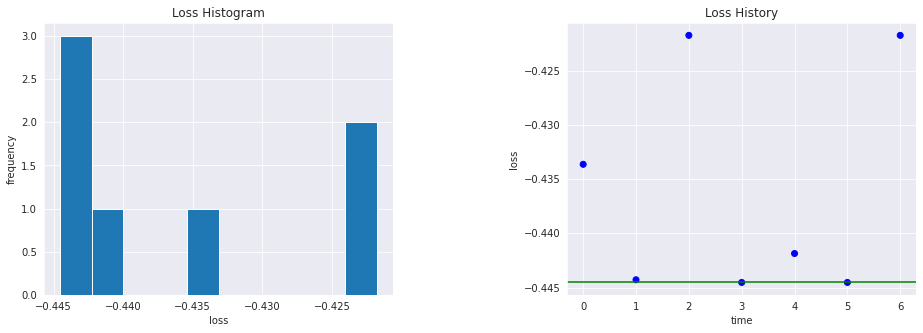

In [ ]:
plot_tuning_results(spark_trials)

In [ ]:
# Defining the model but not setting any parameters
# as that will be set below from the best hyperparameters
model = LogisticRegression(class_weight = 'balanced', n_jobs = -1)

get_tuned_test_results(
    X_train = X_train_vectorized,
    y_train = y_train,
    X_test = X_test_vectorized,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = model
)

Best hyperparameters are: {'C': 10}
              precision    recall  f1-score   support

           0       0.96      0.59      0.73    116523
           1       0.09      0.64      0.16      7342

    accuracy                           0.59    123865
   macro avg       0.53      0.62      0.44    123865
weighted avg       0.91      0.59      0.70    123865



In [ ]:
# Clear up memory.
del model
del spark_trials
gc.collect();

#### Model Iteration 2: Random Forest
This iteration of the model replaces the logistic regression model with a random forest model to see if it performs any better with the new word embedding feature space.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    model_n_estimators = params['n_estimators']
    model_class_weight = params['class_weight']
    model_ccp_alpha = params['ccp_alpha']
    model_max_depth = params['max_depth']

    # Create the model.
    model = RandomForestClassifier(
        n_estimators = model_n_estimators,
        class_weight = model_class_weight,
        ccp_alpha = model_ccp_alpha,
        max_depth = model_max_depth
    )

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = model, 
            X = X_train_vectorized, 
            y = y_train,
            cv = 3,
            scoring = 'f1_macro',
        ).mean()

    del model
    gc.collect();

    # Return metric as a negative value since we want to maximize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
  'n_estimators': hp.choice('n_estimators', [10, 25, 50]),
  'class_weight': hp.choice('class_weight', ['balanced', 'balanced_subsample']),
  'ccp_alpha': hp.choice('ccp_alpha', [0, 0.1, 1, 10]),
  'max_depth': hp.choice('max_depth', [10, 20])
}

# Use SparkTrials to tune concurrently
spark_trials = SparkTrials(parallelism = 2)
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = spark_trials,
    max_evals = 24
)

100%|██████████| 24/24 [2:57:15<00:00, 443.16s/trial, best loss: -0.5194988028566371]


Total Trials: 24: 24 succeeded, 0 failed, 0 cancelled.


Showing Histogram of 24 jobs
avg best error: -0.5194988028566371


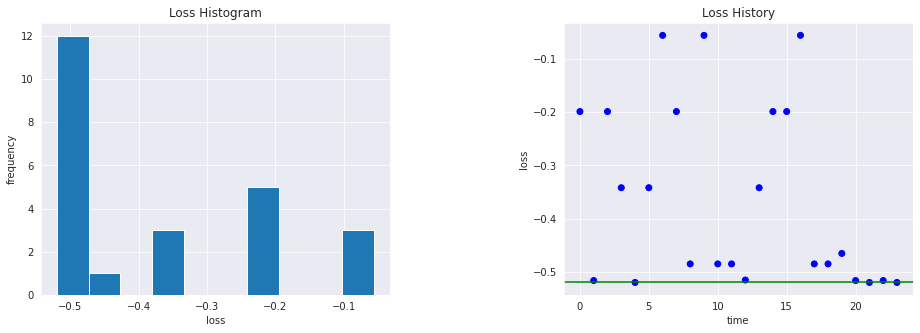

In [ ]:
plot_tuning_results(spark_trials)

In [ ]:
# Recreate the model used in objective function but do not set
# any parameters since we will set it later below.
model = RandomForestClassifier(n_jobs = -1)

get_tuned_test_results(
    X_train = X_train_vectorized,
    y_train = y_train,
    X_test = X_test_vectorized,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = model
)

Best hyperparameters are: {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 25}
              precision    recall  f1-score   support

           0       0.94      0.97      0.95    116523
           1       0.12      0.08      0.09      7342

    accuracy                           0.91    123865
   macro avg       0.53      0.52      0.52    123865
weighted avg       0.89      0.91      0.90    123865



In [ ]:
# Clear up memory.
del model
del spark_trials
gc.collect();

We can see that the Word2Vec plus random forest does perform markedly better - **51.94%** F1 (52% F1 on test) - compared to the 44.45% F1 for the Word2Vec plus logistic regression. However, this underperforms the best TF-IDF/logistic regression combination (54.94%). 

### Approach 3: Transfer Learning
For this third approach, I'm going to try to see if transfer learning can bring improvements to our modeling. Transfer learning is the process of taking a large pretrained model that has been trained on a massive corpus of text and applying it to your problem. To make the transfer learning model work for your problem, instead of having to train an entire complex model from scratch, you just need to train the last couple layers. This, theoretically, allows us to leverage really good models for our problems without having to spend a lot of resources to train it.

The library I'm using for this is `fastai`. I'm using the built-in pretrained model that `fastai` has which is the ASGD Weight-Dropped LSTM model trained on WikiText-103 dataset, a collection of Wikipedia articles.

In [ ]:
# Use the fastai API to create PyTorch data loader for text data.
data_loader = TextDataLoaders.from_df(
    pd.concat(
        [X_train, y_train], 
        axis = 1
    ),
    text_col = 'essay_preprocessed', 
    label_col = 'is_exciting',
    bs = 64, 
    device = 'cuda',
    num_workers = 0,
    seed = 1
)

Since we have an imbalanced label distribution, I need to change the normal cross-entropy loss function to a weighted cross-entropy loss function in order to account for the difference in distribution. The cell block below allows me to get the class weights so I can pass it into the cross-entropy loss function for training.

In [ ]:
def get_weights(dls):
   '''Get class weights to be used for cross-entropy loss.'''
    # 0th index would provide the vocab from text
    # 1st index would provide the vocab from classes
    classes = dls.vocab[1]

    # Combine the above into a single
    train_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))
    label_counter = Counter(train_lbls)
    n_most_common_class = max(label_counter.values()); 
    print(f'Occurrences of the most common class: {n_most_common_class}')
    
    # Source: https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/9
    weights = [
        n_most_common_class / v for k, v in label_counter.items() if v > 0
    ]
    
    return weights 

# Calculate the class weights.
weights = get_weights(data_loader) 
class_weights = torch.FloatTensor(weights).to(data_loader.device)

Occurrences of the most common class 372912


In [ ]:
# Set max number of epochs to train.
epochs = 10

# Create scorers for F1 scores of `is_exciting`
f1_score_pos = F1Score(pos_label = 1)
f1_score_neg = F1Score(pos_label = 0)
f1_score_macro = F1Score(average = 'macro')

# Define the fastai model.
learn = text_classifier_learner(
    data_loader, 
    AWD_LSTM, 
    drop_mult = 0.5, 
    metrics = [accuracy, f1_score_pos, f1_score_neg, f1_score_macro]
)

# Sets model loss function to the cross-entropy loss with class weights
learn.loss_func = CrossEntropyLossFlat(weight = class_weights)

# Add callbacks for showing graph of train/validation loss as well
# as an early stopping callback for stopping training early
learn.add_cbs([ShowGraphCallback(), EarlyStoppingCallback(patience = max(1, 0.1 * epochs))])

# Ensures the model runs on the GPU.
learn.model = learn.model.cuda()

Below is the cell to train the model. What `fine_tune` does is freeze all the layers of the AWD-LSTM model except for the head (last layer) and train the model for a set number of epochs (1 is default; set to 5 below). Then it unfreezes the entire model (i.e., allows all the layers to be trained) and trains the model for another set of epochs (`epochs` as defined below).

epoch,train_loss,valid_loss,accuracy,f1_score,f1_score,f1_score,time
0,0.807712,0.631794,0.608784,0.161454,0.744880,0.453167,26:23
1,0.814068,0.630466,0.684421,0.163497,0.805527,0.484512,26:19
2,0.801238,0.632110,0.623921,0.157373,0.757944,0.457659,26:40


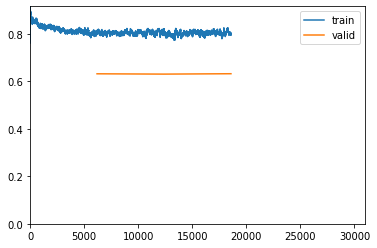

No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,accuracy,f1_score,f1_score,f1_score,time
0,0.619018,0.595214,0.649625,0.177840,0.777375,0.477608,46:20
1,0.597418,0.598971,0.701133,0.181703,0.817181,0.499442,45:47


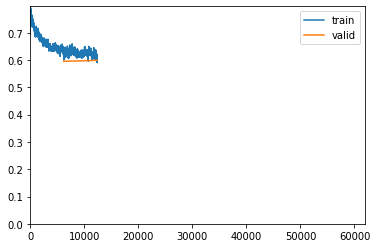

No improvement since epoch 0: early stopping


In [ ]:
learn.fine_tune(epochs = epochs, freeze_epochs = 5)

Once the model is trained, I get the results from the test set. It doesn't perform as well as our other approaches (50% test F1). This could be due to the fact that the model trained for only 5 epochs. If I allowed the model to train for longer by setting the early-stopping criteria to be more lenient (e.g., increasing the `patience` parameter), perhaps I would have been able to get better results.

In [ ]:
preds, _ = learn.get_preds(dl = learn.dls.test_dl(X_test))
labels = np.argmax(preds.numpy(), 1)

In [ ]:
print(classification_report(y_test, labels))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82    116523
           1       0.11      0.55      0.18      7342

    accuracy                           0.70    123865
   macro avg       0.53      0.63      0.50    123865
weighted avg       0.91      0.70      0.78    123865



## Overall Results

From the results below, our best model in terms of F1 was the bag-of-words model using logistic regression and TF-IDF vectorization. The highlighted fields show where those models beat the baseline.

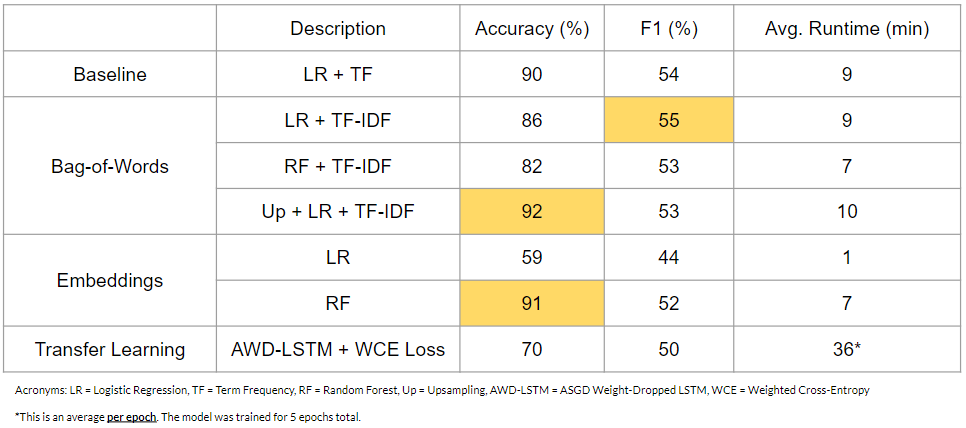

## Conclusion
Based on the fact that the F1 was around 50% - even with upsampling - this tells me that there is not enough information in the essays to determine if it is an "exciting" project of not. I would have to use other features from the other files available (teacher donations, project details, resource information, etc.) to potentially create more informative features for modeling.

## Future Work
There are some improvements and/or changes that can be made to this project such as:
* changing the upsampling strategy from random oversampling (SMOTE, ADASYN, Snorkel data augmentation)
* trying additional models besides logistic regression and random forest
* training the transfer learning model for more epochs
* experimenting with more transfer learning parameters (learning rate, batch size, etc.)
* training a language model on the essays (include the middle step from the transfer learning process)